In [2]:
import pickle
from pointpats import centrography
from matplotlib.patches import Ellipse
import numpy as np
import pandas as pd
from shapely.geometry import Point
from scipy.spatial.distance import cdist
import ast
import geopandas as gpd
import matplotlib.pyplot as plt
from matplotlib.ticker import ScalarFormatter, MaxNLocator
from matplotlib_scalebar.scalebar import ScaleBar
from mpl_toolkits.axes_grid1 import make_axes_locatable

Mapping existing tech centers

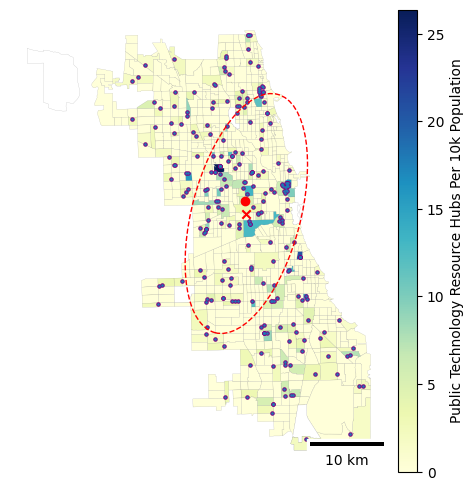

In [3]:
# chicago
chicago = gpd.read_file('data/chicago_tract_all.shp')
chicago['ptr_10k'] = chicago['TECH_CNT'] / chicago['Total_Pop'] * 10000

# public tech resource
tech_sites = pd.read_csv('data/Public_Technology_Resources_20240705.csv', encoding='latin-1')
tech_sites['coord'] = tech_sites['LOCATION'].str.split('\n').str[2].apply(ast.literal_eval)
tech_sites['lat'] = tech_sites['coord'].apply(lambda x: x[0])
tech_sites['lon'] = tech_sites['coord'].apply(lambda x: x[1])
tech_sites['geometry'] = tech_sites.apply(lambda row: Point(row['lon'], row['lat']), axis=1)
tech_sites_gdf = gpd.GeoDataFrame(tech_sites, geometry='geometry', crs=4326).to_crs(chicago.crs)
tech_sites_gdf['x'] = tech_sites_gdf.geometry.x
tech_sites_gdf['y'] = tech_sites_gdf.geometry.y

mean_center = centrography.mean_center(tech_sites_gdf[["x", "y"]])
med_center = centrography.euclidean_median(tech_sites_gdf[["x", "y"]])
major, minor, rotation = centrography.ellipse(tech_sites_gdf[["x", "y"]])
ellipse = Ellipse(
    xy=mean_center,  # center the ellipse on our mean center
    width=major * 2,  # centrography.ellipse only gives half the axis
    height=minor * 2,
    angle=np.rad2deg(
        rotation
    ),  # Angles for this are in degrees, not radians
    facecolor="none",
    edgecolor="red",
    linestyle="--",
    label="Std. Ellipse",
)

fig, ax = plt.subplots(1, 1, figsize=(9, 6))
plot = chicago.plot(ax=ax, column='ptr_10k', edgecolor='gray', linewidth=0.1, cmap='YlGnBu', missing_kwds={'color': 'white'})
tech_sites_gdf.plot(ax=ax, markersize=5, color="Purple")
ax.set_axis_off()
scalebar = ScaleBar(1, location='lower right')
ax.add_artist(scalebar)

divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.1)
cbar = plt.colorbar(plot.get_children()[0], cax=cax)
cbar.set_label('Public Technology Resource Hubs Per 10k Population')

ax.scatter(tech_sites_gdf["x"], tech_sites_gdf["y"], s=0.75)
ax.scatter(*mean_center, color="red", marker="x", label="Mean Center")
ax.scatter(
    *med_center, color="red", marker="o", label="Median Center"
)
ax.add_patch(ellipse)

plt.subplots_adjust(wspace=0)
plt.savefig("ptr_10k.eps", format="eps", bbox_inches='tight')
plt.show()

In [66]:
chicago_centroids = gpd.read_file('data/chicago_centroids_all.shp')
# numbers of demand and service locations
I, J = chicago_centroids.shape[0], chicago_centroids.shape[0]

# total demands
p_all = chicago_centroids['Total_Pop'].sum()
# demand at location i
p_i = chicago_centroids['Total_Pop'].to_numpy()
# total supply
c_all = 252
# weighted average accessibility
bar_a = c_all / p_all

# vulnerable groups
groups = ['AGE', 'RACE', 'ETH', 'EDU', 'LAN', 'INC', 'COM', 'INT', 'DIS']
K, p_ik = len(groups), chicago_centroids[groups].to_numpy()

# distance matrix
points = chicago_centroids['geometry'].apply(lambda geom: (geom.x, geom.y)).tolist()
d = cdist(points, points, metric='euclidean')

beta_all = [0.1, 0.01, 0.001]

for idx, beta in enumerate(beta_all):
    f = np.exp(-beta * d)
    g = f / np.sum(p_i[:, np.newaxis] * f, axis=0)
    X = chicago_centroids['TECH_CNT'].to_numpy()
    a_i = np.dot(X, g) * 10000
    a_k = np.dot(p_ik.T, a_i) / np.sum(p_ik, axis=0)

    H = np.sqrt(np.sum((a_i - bar_a) ** 2 * p_i) / p_all)
    V = np.power(np.prod(a_k), 1 / K)

    print(beta, H, V, a_k)

0.1 2.3840043421554933 1.0734645484925684 [0.99743484 1.09227511 1.00521199 1.05515624 0.96673806 1.12669366
 1.11187435 1.17264309 1.15335268]
0.01 2.375992931268944 1.0734324988409962 [0.997604   1.09251597 1.00422117 1.05501089 0.96611839 1.12694289
 1.11274876 1.17218586 1.15391685]
0.001 1.074857559868498 1.0020727731885077 [0.96970118 1.04916486 0.91810325 1.00546095 0.89956011 1.0445899
 1.04630228 1.05632436 1.0445386 ]


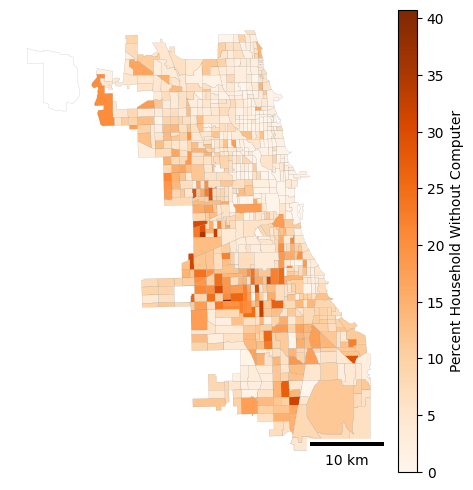

In [48]:
fig, ax = plt.subplots(1, 1, figsize=(9, 6))
chicago['com_pct'] = chicago['COM'] * 100
plot = chicago.plot(ax=ax, column='com_pct', edgecolor='gray', linewidth=0.1, cmap='Oranges', missing_kwds={'color': 'white'})
ax.set_axis_off()
scalebar = ScaleBar(1, location='lower right')
ax.add_artist(scalebar)

divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.1)
cbar = plt.colorbar(plot.get_children()[0], cax=cax)
cbar.set_label('Percent Household Without Computers')
plt.savefig("wo_com.eps", format="eps", bbox_inches='tight')

Map parameters

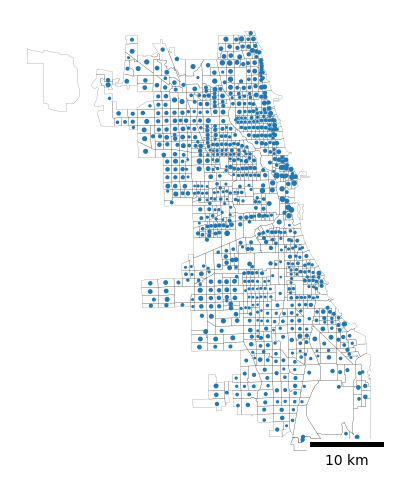

In [31]:
chicago_centroids = gpd.read_file('data/chicago_centroids_all.shp')
chicago = gpd.read_file('data/chicago_tract_all.shp')
fig, ax = plt.subplots(1, 1, figsize=(9, 6))
plot = chicago.plot(ax=ax, color = 'None', linewidth=0.1)
chicago_centroids.plot(ax=ax, marker = 'o', markersize = (chicago_centroids['Total_Pop'])/1000,  legend=True)

ax.set_axis_off()
scalebar = ScaleBar(1, location='lower right')
ax.add_artist(scalebar)


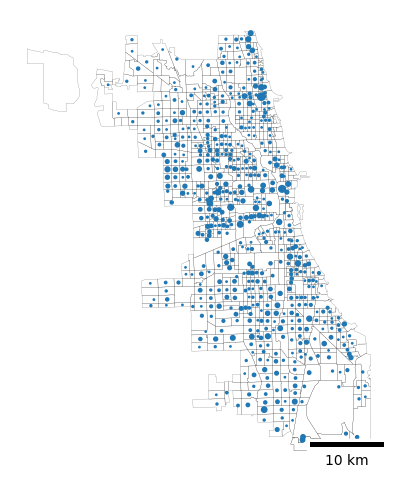

In [28]:
chicago_centroids = gpd.read_file('data/chicago_centroids_all.shp')
chicago = gpd.read_file('data/chicago_tract_all.shp')
fig, ax = plt.subplots(1, 1, figsize=(9, 6))
plot = chicago.plot(ax=ax, color = 'None', linewidth=0.1)
chicago_centroids.plot(ax=ax, marker = 'o', markersize = (chicago_centroids['MAX_CAP']), legend=True)
ax.set_axis_off()
scalebar = ScaleBar(1, location='lower right')
ax.add_artist(scalebar)


Pareto front

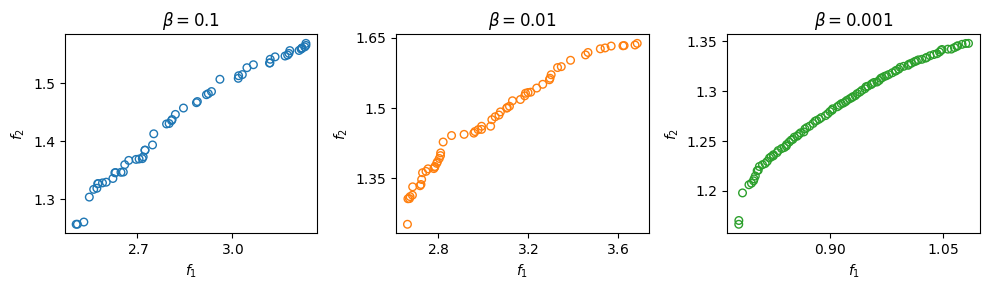

In [2]:
beta_all = [0.1, 0.01, 0.001]

cmap = plt.get_cmap("tab10")

num_cols = 3
num_rows = 1
fig, axs = plt.subplots(num_rows, num_cols, figsize=(10, 3))

for idx, beta in enumerate(beta_all):
    # ax = axs[idx // num_cols, idx % num_cols]
    ax = axs[idx]
    F = pickle.load(open('data/obj/F_beta' + str(beta) + '.pickle', "rb"))
    ax.scatter(F[:, 0], -F[:, 1], s=30, facecolors='none', edgecolors=cmap(idx), label=beta)
    ax.set_xlabel("$f_1$")
    ax.set_ylabel("$f_2$")
    ax.set_title(f'$\\beta={beta}$')

    ax.xaxis.set_major_formatter(ScalarFormatter(useMathText=True, useOffset=False))
    ax.xaxis.set_major_locator(MaxNLocator(nbins=3))
    ax.yaxis.set_major_formatter(ScalarFormatter(useMathText=True, useOffset=False))
    ax.yaxis.set_major_formatter('{x:.7}')
    ax.yaxis.set_major_locator(MaxNLocator(nbins=4))

plt.tight_layout()
# plt.savefig("pareto_front.png", format="png", bbox_inches='tight')
plt.savefig("pareto_front.eps", format="eps", bbox_inches='tight')
plt.show()

0.1 [ 2.50675549 -1.25717231] [ 2.80951686 -1.4372363 ] [ 3.23176478 -1.56813178]
0.01 [ 2.66349256 -1.25136533] [ 3.03909489 -1.47506113] [ 3.6860555  -1.63825118]
0.001 [ 0.77770255 -1.16661836] [ 0.92223888 -1.29068442] [ 1.08467258 -1.34776982]


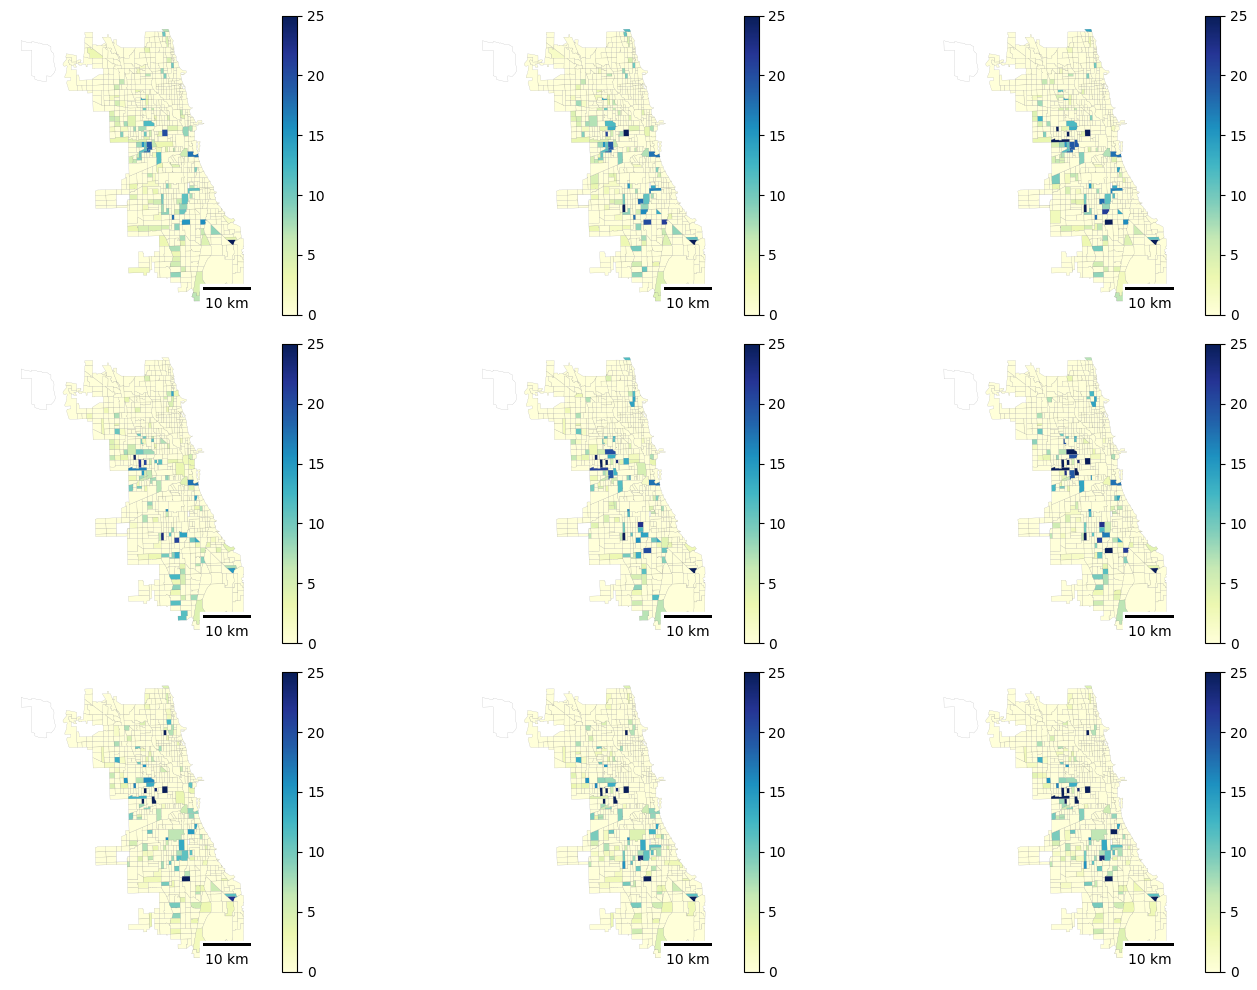

In [54]:
from matplotlib.colors import Normalize

beta_all = [0.1, 0.01, 0.001]

chicago_centroids = gpd.read_file('data/chicago_centroids_all.shp')
chicago = gpd.read_file('data/chicago_tract_all.shp')

fig, axs = plt.subplots(nrows=len(beta_all), ncols=3, figsize=(15, 10))
for idx, beta in enumerate(beta_all):
    F = pickle.load(open('data/obj/F_beta' + str(beta) + '.pickle', "rb"))
    X = pickle.load(open('data/sols/X_beta' + str(beta) + '.pickle', "rb"))

    largest_index = np.argmax(F[:, 0])
    smallest_index = np.argmin(F[:, 0])
    median_index = np.argsort(F[:, 0])[len(F[:, 0]) // 2]

    F1 = F[smallest_index]
    F2 = F[median_index]
    F3 = F[largest_index]
    print(beta, F1, F2, F3)
    
    X1 = X[smallest_index]
    X2 = X[median_index]
    X3 = X[largest_index]    
    
    chicago_centroids['x1'] = X1 / chicago_centroids['Total_Pop'] * 10000
    chicago_centroids['x2'] = X2 / chicago_centroids['Total_Pop'] * 10000
    chicago_centroids['x3'] = X3 / chicago_centroids['Total_Pop'] * 10000
    chicago_merged = chicago.merge(chicago_centroids[['GISJOIN', 'x1', 'x2', 'x3']], on='GISJOIN', how="left")

    for col_idx, x_var in enumerate(['x1', 'x2', 'x3']):
        
        ax = axs[idx, col_idx]
        chicago_merged.plot(column=x_var, edgecolor='gray', linewidth=0.1, cmap='YlGnBu', 
                            ax=ax, legend=True, vmin=0, vmax=25, 
                            missing_kwds={'color': 'white'})
        ax.set_axis_off()
        scalebar = ScaleBar(1, location='lower right')
        ax.add_artist(scalebar)

plt.tight_layout()
plt.savefig("pareto_front_maps.eps", format="eps", bbox_inches='tight')
plt.show()

In [41]:
chicago_centroids

,GISJOIN,Lon_w,Lat_w,STATEFP,COUNTYFP,TRACTCE,GEOID,NAME,NAMELSAD,MTFCC,...,SC_CNT,WC_CNT,SS_CNT,MAX_CAP,Total_Pop,Total_HH,geometry,x1,x2,x3
0,G1700310010100,684221.785904,536506.549117,17,031,010100,17031010100,101,Census Tract 101,G5020,...,0,0,10,11,4284,2322,POINT (-9759340.565 5164157.294),46.685341,46.685341,46.685341
1,G1700310010201,683361.585376,535848.771305,17,031,010201,17031010201,102.01,Census Tract 102.01,G5020,...,0,0,1,2,8210,3028,POINT (-9760578.291 5163380.371),0.000000,0.000000,0.000000
2,G1700310010202,684032.517605,535872.761074,17,031,010202,17031010202,102.02,Census Tract 102.02,G5020,...,0,0,11,12,2865,1223,POINT (-9759670.846 5163333.772),0.000000,0.000000,0.000000
3,G1700310010300,684542.829846,535948.251783,17,031,010300,17031010300,103,Census Tract 103,G5020,...,0,0,0,0,6237,3047,POINT (-9758973.862 5163374.659),0.000000,0.000000,0.000000
4,G1700310010400,685225.899687,534657.507557,17,031,010400,17031010400,104,Census Tract 104,G5020,...,0,0,0,0,4473,2058,POINT (-9758206.032 5161572.423),0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
784,G1700310843600,691297.498538,512997.710149,17,031,843600,17031843600,8436,Census Tract 8436,G5020,...,0,0,2,2,2966,1478,POINT (-9752606.327 5132012.495),0.000000,0.000000,0.000000
785,G1700310843800,688549.198970,512349.678858,17,031,843800,17031843800,8438,Census Tract 8438,G5020,...,0,0,1,3,1479,719,POINT (-9756377.410 5131473.722),135.226504,135.226504,135.226504
786,G1700310843900,694302.110504,509607.030347,17,031,843900,17031843900,8439,Census Tract 8439,G5020,...,0,0,4,4,3700,2201,POINT (-9748972.781 5127151.481),0.000000,27.027027,0.000000
787,G1700310844600,690000.312414,513706.489801,17,031,844600,17031844600,8446,Census Tract 8446,G5020,...,0,0,3,3,2275,828,POINT (-9754265.794 5133107.467),0.000000,0.000000,0.000000


Runtime

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Read data from CSV
df = pd.read_csv("data/runtime.csv")

# Set up bar chart
bar_width = 0.25
fig, ax = plt.subplots(figsize=(6, 3))

# Use Viridis color palette
colors = plt.cm.cividis_r(np.linspace(0, 1, len(df['prob'].unique())))

# Set position of bar on X axis 
br1 = np.arange(3)
br2 = br1 + bar_width

# Plot bars for each prob
for i, (prob, group) in enumerate(df.groupby('prob')):
    x_positions = br1 if prob == 'moo' else br2
    ax.bar(x_positions, group['runtime'], label=f'{prob}', color=colors[i], width=bar_width)

ax.set_xlabel('$\\beta$')
ax.set_ylabel('Runtime (s)')

# Set x-axis ticks and labels
ax.set_xticks(br1 + bar_width / 2)
ax.set_xticklabels(df['beta'].unique())

ax.legend()
ax.grid(True)
plt.savefig("runtime.eps", format="eps", bbox_inches='tight')
plt.show()

Compare with MAEP

In [108]:
chicago_centroids = gpd.read_file('data/chicago_centroids_all.shp')
# numbers of demand and service locations
I, J = chicago_centroids.shape[0], chicago_centroids.shape[0]

# total demands
p_all = chicago_centroids['Total_Pop'].sum()
# demand at location i
p_i = chicago_centroids['Total_Pop'].to_numpy()
# total supply
c_all = 250
# weighted average accessibility
bar_a = c_all / p_all

# vulnerable groups
groups = ['AGE', 'RACE', 'ETH', 'EDU', 'LAN', 'INC', 'COM', 'INT', 'DIS']
K, p_ik = len(groups), chicago_centroids[groups].to_numpy()

# distance matrix
points = chicago_centroids['geometry'].apply(lambda geom: (geom.x, geom.y)).tolist()
d = cdist(points, points, metric='euclidean')

beta_all = [0.1, 0.01, 0.001]

for idx, beta in enumerate(beta_all):
    f = np.exp(-beta * d)
    g = f / np.sum(p_i[:, np.newaxis] * f, axis=0)
    F1 = pickle.load(open('data/obj/F_beta' + str(beta) + '.pickle', "rb"))
    X1 = pickle.load(open('data/sols/X_beta' + str(beta) + '.pickle', "rb"))
    V1 = -F1[:, 1]
    a_i1 = np.dot(X1, g) * 10000
    a_k1 = np.dot(a_i1, p_ik) / np.sum(p_ik, axis=0)

    F2 = pickle.load(open('data/obj/F_maep_beta' + str(beta) + '.pickle', "rb"))
    X2 = pickle.load(open('data/sols/X_maep_beta' + str(beta) + '.pickle', "rb"))
    a_i2 = np.dot(g, X2) * 10000
    a_k2 = np.dot(p_ik.T, a_i2) / np.sum(p_ik, axis=0)
    V2 = np.power(np.prod(a_k2), 1 / K)

    print("AETP, V:", beta, np.mean(V1), np.mean(a_k1, axis=0))
    print("MAEP, V:", beta, V2, a_k2)

AETP, V: 0.1 1.346416954290966 [1.20332798 1.44890877 0.98514224 1.41816891 0.91224115 1.5290935
 1.63148254 1.65989331 1.59035182]
MAEP, V: 0.1 1.0219122555349665 [0.9237518  1.12783912 0.94710933 1.08343918 0.85028076 1.08865952
 1.0361169  1.08046454 1.09708852]
AETP, V: 0.01 1.4358082267267924 [1.30446418 1.58798564 0.97698488 1.53301002 0.90757078 1.68018369
 1.75941468 1.83985301 1.7012043 ]
MAEP, V: 0.01 1.2781953442009053 [1.1590416  1.45884542 0.94268261 1.35749959 0.83724407 1.44814484
 1.49299367 1.56138968 1.48911496]
AETP, V: 0.001 1.237881315457767 [1.14760314 1.32812021 1.04020675 1.3064776  0.95063259 1.35030587
 1.37352284 1.38345715 1.32938344]
MAEP, V: 0.001 1.0788445744939135 [1.01140148 1.1598191  0.99689438 1.10634247 0.91550827 1.1353397
 1.1253256  1.1480231  1.13962099]


In [101]:
chicago_centroids = gpd.read_file('data/chicago_centroids_all.shp')
# numbers of demand and service locations
I, J = chicago_centroids.shape[0], chicago_centroids.shape[0]

# total demands
p_all = chicago_centroids['Total_Pop'].sum()
# demand at location i
p_i = chicago_centroids['Total_Pop'].to_numpy()
# total capacities
c_all = 250
# weighted average accessibility
bar_a = c_all / p_all

# vulnerable groups
groups = ['AGE', 'RACE', 'ETH', 'EDU', 'LAN', 'INC', 'COM', 'INT', 'DIS']
K, p_ik = len(groups), chicago_centroids[groups].to_numpy()

# distance matrix
points = chicago_centroids['geometry'].apply(lambda geom: (geom.x, geom.y)).tolist()
d = cdist(points, points, metric='euclidean')

beta_all = [0.1, 0.01, 0.001]

for idx, beta in enumerate(beta_all):
    f = np.exp(-beta * d)
    g = f / np.sum(p_i[:, np.newaxis] * f, axis=0)
    F1 = pickle.load(open('data/obj/F_beta' + str(beta) + '.pickle', "rb"))
    H1 = F1[:, 0]

    F2 = pickle.load(open('data/obj/F_maep_beta' + str(beta) + '.pickle', "rb"))
    H2 = np.sqrt(1 / p_all * F2)

    print("AETP, H:", beta, F1[:, 0], np.mean(H1))
    print("MAEP, H:", beta, F2, H2)

AETP, H: 0.1 [3.21006248 2.65553064 2.92366927 2.6015909  2.93378109 2.62263205
 3.21652595 2.64813604 3.03103785 2.71825411 3.01820194 3.2190394
 2.57657228 2.66002552 2.71541818 3.11682597 3.13440474 3.17821104
 2.51063995 2.58977671 3.11818984 2.74774488 2.80951686 2.72377581
 2.84534258 2.91781661 3.0193928  2.79198383 2.50675549 2.88914612
 2.54825591 3.06603254 2.96036305 2.81981972 2.88630879 2.56201444
 3.17397964 2.62890182 3.04560504 2.69573185 3.23176478 3.22799263
 2.63132142 3.18090044 2.57213184 2.70534991 2.80773354 3.21906465
 3.11904353 2.75158624 3.16589698 2.72409121 2.80006219 3.23173997
 2.53103945 2.57478253 2.6727497 ] 2.8628818373908618
MAEP, H: 0.1 [16665091.86511432] [2.47269463]
AETP, H: 0.01 [2.79371263 3.23868288 2.95897078 3.03364285 2.99324355 2.96368491
 2.80514302 2.78565421 2.66349256 2.99334447 3.16612042 2.68557511
 2.75492789 3.67631343 2.91559047 2.71948728 2.67494602 2.74596191
 3.57008021 2.66551938 3.18531667 2.78458503 2.97806432 2.67240982
 2.